# Introduction

Ce notebook est dédié à l'accomplissement du projet machine learning, ayant pour objectif l'identification des enchères placées par des robots en utilisant le dataset fourni. Ce projet implique l'analyse approfondie de deux ensembles de données distincts : l'un renfermant les informations des enchérisseurs et l'autre comprenant des enchères effectuées via des appareils mobiles.


Dans cette analyse, nous examinons les données d'enchères (bids) et les données d'entraînement (train) pour détecter les activités frauduleuses d'enchérisseurs. Nous commençons par charger les données et définir les types de données appropriés pour réduire l'utilisation de la mémoire.


In [3]:
import pandas as pd

# Defining data types to reduce memory usage
dtypes_bids = {
    'bid_id': 'uint32',
    'bidder_id': 'category',
    'auction': 'category',
    'merchandise': 'category',
    'device': 'category',
    'time': 'uint32',
    'country': 'category',
    'ip': 'category',
    'url': 'category'
}

dtypes_train = {
    'bidder_id': 'category',
    'payment_account': 'category',
    'address': 'category',
    'outcome': 'uint8'
}

# Read data in chunks to reduce memory usage
chunksize = 10 ** 6  # Adjust chunk size as needed

# Initialize empty DataFrame for each CSV file
df_bids = pd.DataFrame()
df_train = pd.DataFrame()

# Read bids.csv in chunks
for chunk in pd.read_csv('bids.csv', dtype=dtypes_bids, chunksize=chunksize):
    df_bids = pd.concat([df_bids, chunk])


In [4]:
# Load data
df_train = pd.read_csv('train.csv')


In [5]:
df_train.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [6]:
df_bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,3719558736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,3719558736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,3719558736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,3719558736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,3719558736,in,145.138.5.37,vasstdc27m7nks3


# Exploration des données d'enchères (Bids)

Nous commençons par examiner les données d'enchères pour comprendre les comportements des enchérisseurs. Nous examinons les enchères par enchérisseur, par enchère, par catégorie de marchandise et par pays.

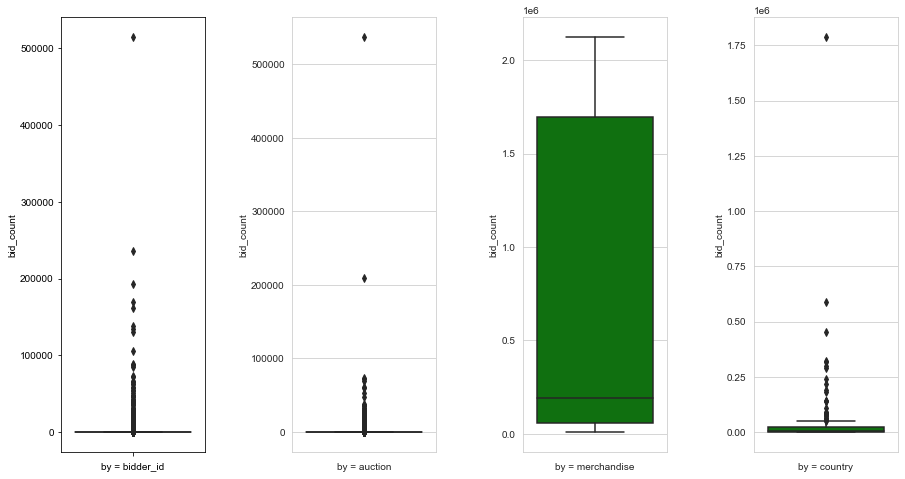

In [16]:
import seaborn as sns

# Grouping the DataFrame by different columns and counting the number of bids
group_df = []
group_df.append(pd.DataFrame(df_bids.groupby(['bidder_id']).size().reset_index(name="bid_count")).dropna())
group_df.append(pd.DataFrame(df_bids.groupby(['auction']).size().reset_index(name="bid_count")).dropna())
group_df.append(pd.DataFrame(df_bids.groupby(['merchandise']).size().reset_index(name="bid_count")).dropna())
group_df.append(pd.DataFrame(df_bids.groupby(['country']).size().reset_index(name="bid_count")).dropna())

# Names for the plots
names = ['by = bidder_id', 'by = auction', 'by = merchandise', 'by = country']

# Creating a figure and subplots
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.6)

# Plotting each group_df using box plots
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(y='bid_count', data=group_df[i], color='green', orient='v')
    ax.set_xlabel(names[i])


# Extraction de caractéristiques des enchérisseurs
Nous extrayons plusieurs caractéristiques pour chaque enchérisseur à partir des données d'enchères. Ces caractéristiques incluent le nombre total d'enchères effectuées par chaque enchérisseur, le nombre d'enchères uniques par catégorie de marchandise, le nombre d'appareils utilisés pour enchérir, le nombre de pays et d'adresses IP uniques associées à chaque enchérisseur, et le nombre d'URL uniques visitées.

Nous calculons également des caractéristiques de moyenne telles que le nombre moyen de pays distincts par enchère et le nombre moyen d'URLs distinctes par enchère pour chaque enchérisseur. Ces caractéristiques nous donnent un aperçu de la diversité des activités des enchérisseurs.

# Caractéristiques de Compte

Nous calculons plusieurs caractéristiques de compte pour chaque enchérisseur, notamment :

bid_count : le nombre total d'enchères effectuées par l'enchérisseur.

auction_count : le nombre d'enchères uniques auxquelles l'enchérisseur a participé.

merc_count : le nombre de catégories de marchandises uniques pour lesquelles l'enchérisseur a enchéri.

device_count : le nombre d'appareils uniques utilisés par l'enchérisseur pour enchérir.

country_count : le nombre de pays uniques à partir desquels l'enchérisseur a enchéri.

ip_count : le nombre d'adresses IP uniques associées à l'enchérisseur.

url_count : le nombre d'URL uniques visitées par l'enchérisseur. 

Ces caractéristiques de compte nous donnent un aperçu de l'activité globale de chaque enchérisseur, ainsi que de sa diversité dans les catégories de marchandises, les appareils utilisés, les pays ciblés, les adresses IP associées et les sites Web visités.

In [7]:
# Feature of counts
feature_counts = df_bids.groupby('bidder_id').agg(
    bid_count=('bid_id', 'nunique'),
    auction_count=('auction', 'nunique'),
    merc_count=('merchandise', 'nunique'),
    device_count=('device', 'nunique'),
    country_count=('country', 'nunique'),
    ip_count=('ip', 'nunique'),
    url_count=('url', 'nunique')
).reset_index()


# Caractéristiques de Moyenne

En plus des caractéristiques de compte, nous calculons également des caractéristiques de moyenne pour chaque enchérisseur, comprenant :

average_distinct_country_per_auction : le nombre moyen de pays distincts par enchère pour l'enchérisseur.

average_distinct_urls_per_auction : le nombre moyen d'URL distinctes par enchère pour l'enchérisseur.

average_bids_per_auction : le nombre moyen d'enchères par enchère pour l'enchérisseur.

Ces caractéristiques de moyenne nous aident à comprendre la diversité et l'intensité des activités des enchérisseurs lors des 
enchères en ligne. Par exemple, un nombre moyen élevé d'URLs distinctes par enchère pourrait indiquer une recherche approfondie de produits, tandis qu'un nombre moyen élevé d'enchères par enchère pourrait indiquer une activité d'enchère intensive.

In [10]:
# Feature of averages
feature_avgs = df_bids.groupby('bidder_id').agg(
    average_distinct_country_per_auction=('country', 'nunique'),
    average_distinct_urls_per_auction=('url', 'nunique'),
    average_bids_per_auction=('bid_id', 'count')
).reset_index()

# Display the first few rows of the feature_avgs DataFrame
print("Feature Averages DataFrame:")
feature_avgs.head()

Feature Averages DataFrame:


,bidder_id,average_distinct_country_per_auction,average_distinct_urls_per_auction,average_bids_per_auction
0,001068c415025a009fee375a12cff4fcnht8y,1,1,1
1,002d229ffb247009810828f648afc2ef593rb,1,1,2
2,0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,1,2,3
4,00486a11dff552c4bd7696265724ff81yeo9v,1,7,20


# Caractéristique temporelles

Nous calculons une caractéristique temporelles en mesurant le temps de réponse médian dans les enchères par enchérisseur. Cette caractéristique nous donne des informations sur le comportement temporel des enchérisseurs, comme la fréquence à laquelle ils participent aux enchères et la rapidité de leurs réponses.

In [11]:
# Feature of time series: Median response time in auctions by a bidder
time_lag_feature = df_bids.groupby('bidder_id')['time'].apply(lambda x: np.percentile(np.diff(x), 50) if len(x) > 1 else np.nan).reset_index(name='median_response_time')

# Fusion des caractéristiques avec les données d'entraînement

Enfin, nous fusionnons les caractéristiques extraites avec les données d'entraînement pour former un ensemble de données complet pour la modélisation. Cela nous permettra d'entraîner un modèle de détection de fraude en utilisant à la fois les caractéristiques des enchérisseurs et les étiquettes de fraude fournies dans les données d'entraînement.

##  Caractéristiques Initiales :

bid_id: Identifiant unique pour chaque enchère.
bidder_id: Identifiant unique pour chaque enchérisseur.
auction: Identifiant unique pour chaque enchère.
merchandise: Type de marchandise concernée par l'enchère.
device: Type de dispositif utilisé par l'enchérisseur.
time: Timestamp de l'enchère.
country: Pays d'origine de l'enchérisseur.
ip: Adresse IP de l'enchérisseur.
url: URL de l'enchère.

## Caractéristiques Extrêmes :

bid_count: Nombre total d'enchères par enchérisseur.
auction_count: Nombre total d'enchères distinctes auxquelles l'enchérisseur a participé.
merc_count: Nombre total de types de marchandises différentes auxquelles l'enchérisseur a participé.
device_count: Nombre total de dispositifs différents utilisés par l'enchérisseur.
country_count: Nombre total de pays différents depuis lesquels l'enchérisseur a participé.
ip_count: Nombre total d'adresses IP différentes utilisées par l'enchérisseur.
url_count: Nombre total d'URL différentes associées aux enchères de l'enchérisseur.
average_distinct_country_per_auction: Nombre moyen de pays différents par enchère pour un enchérisseur.
average_distinct_urls_per_auction: Nombre moyen d'URLs différentes par enchère pour un enchérisseur.
average_bids_per_auction: Nombre moyen d'enchères par enchère pour un enchérisseur.
median_response_time: Temps de réponse médian dans les enchères par enchérisseur.


En ajoutant ces caractéristiques extraites, nous cherchons à fournir à notre modèle une vision plus approfondie du comportement des enchérisseurs, ce qui pourrait améliorer la précision de notre modèle de détection de bots. Ces caractéristiques nous permettent de capturer différents aspects du comportement des enchérisseurs, tels que la diversité géographique, la variété des marchandises, la fréquence des enchères et le temps de réponse médian, qui peuvent être indicatifs de comportements suspects associés aux bots.

In [12]:
# Merge features with the training data
train_data_with_features = pd.merge(df_train, feature_counts, on='bidder_id')
train_data_with_features = pd.merge(train_data_with_features, feature_avgs, on='bidder_id')
train_data_with_features = pd.merge(train_data_with_features, time_lag_feature, on='bidder_id', how='left')

In [19]:
# Save the data with features to a CSV file
train_data_with_features.to_csv('train_data_with_features.csv', index=False)


Cette approche holistique nous permet de comprendre les comportements des enchérisseurs à partir des données d'enchères et de créer un ensemble de données enrichi pour la détection de fraudes. Ces étapes sont cruciales pour développer un modèle de détection de fraude robuste qui peut aider à protéger les plateformes d'enchères en ligne contre les activités frauduleuses.

# Chargement et Exploration des Données
### Chargement des Données
Dans la partie suivante, nous chargeons le jeu de données à partir d'un fichier CSV contenant les caractéristiques des enchérisseurs ainsi que la variable cible 'outcome'.

Nous examinons la distribution des classes 'Bots' et 'Humans' en traçant un histogramme. Cette étape est cruciale pour identifier si les classes sont équilibrées ou s'il y a un déséquilibre, ce qui pourrait nécessiter un traitement spécial.

### Gestion des Données Déséquilibrées
Séparation des Classes
Nous séparons les enchérisseurs en deux groupes : la classe majoritaire (humains) et la classe minoritaire (bots).

### Sur-échantillonnage de la Classe Minoritaire
Nous effectuons un sur-échantillonnage de la classe minoritaire (bots) pour équilibrer les classes, en dupliquant certains échantillons.

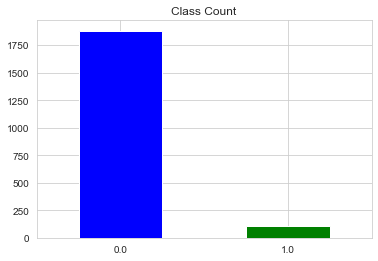

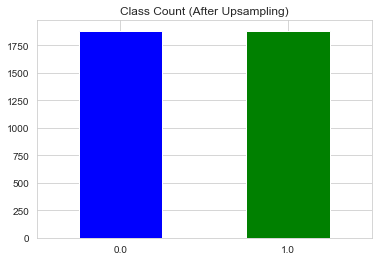

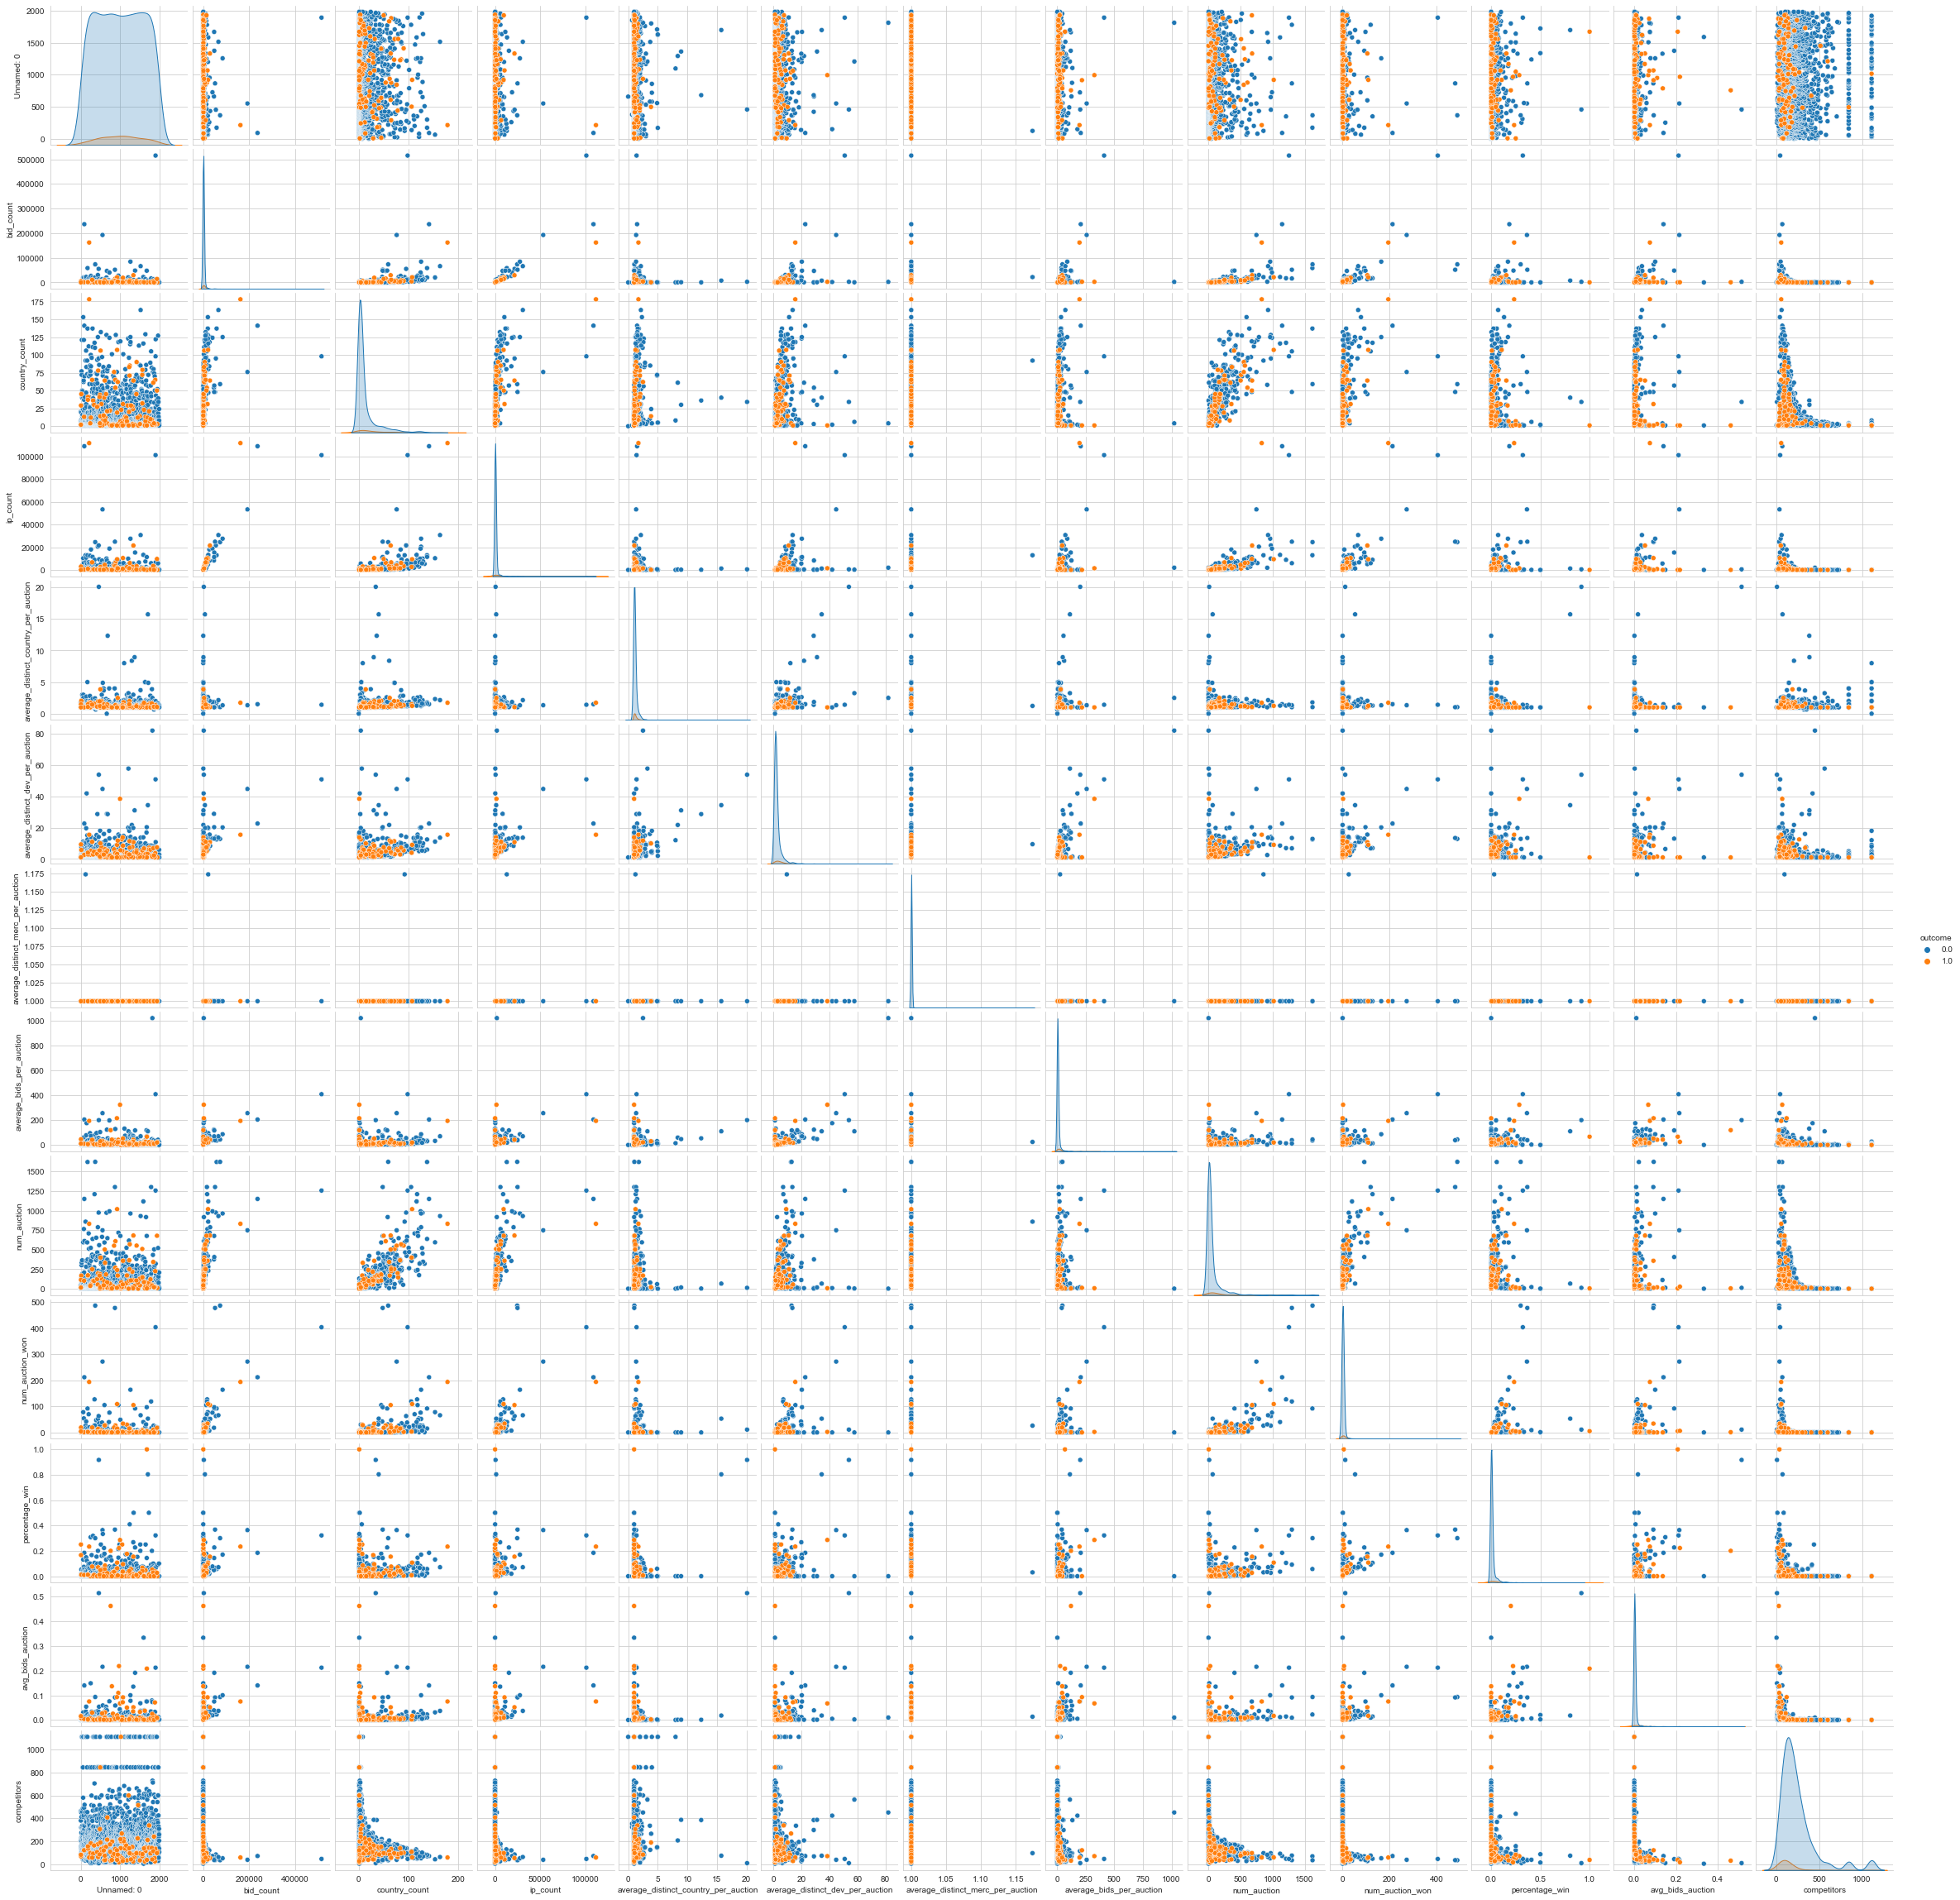

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN
import seaborn as sns
import numpy as np

df = pd.read_csv('feature_of_all_train_df_clean.csv')

# Checking counts of Bots and Humans
target_count = df['outcome'].value_counts()

# Plot count distribution
target_count.plot(kind='bar', color=['b', 'g'], title='Class Count', rot=0)
plt.show()

# Separating majority and minority classes
majority_class = df[df['outcome'] == 0]
minority_class = df[df['outcome'] == 1]

# Upsampling minority class
upsampled_minority_class = minority_class.sample(n=len(majority_class), replace=True, random_state=42)

# Combining majority class with upsampled minority class
df_upsampled = pd.concat([majority_class, upsampled_minority_class])

# Plotting count distribution after upsampling
target_count_upsampled = df_upsampled['outcome'].value_counts()
target_count_upsampled.plot(kind='bar', color=['b', 'g'], title='Class Count (After Upsampling)', rot=0)
plt.show()
# Drop duplicate rows based on all columns except 'outcome'
df_upsampled_unique = df_upsampled.drop_duplicates()

# Pairplot
sns.pairplot(df_upsampled_unique, hue='outcome')
plt.show()


In [51]:
df_upsampled_unique.head()

,Unnamed: 0,bidder_id,bid_count,country_count,ip_count,average_distinct_country_per_auction,average_distinct_dev_per_auction,average_distinct_merc_per_auction,average_bids_per_auction,num_auction,num_auction_won,percentage_win,avg_bids_auction,competitors,outcome
0,0,1395ca662a02245233af951cc7ad8313vk6w0,73,20,59,1.023,1.432,1.0,1.659,44,0,0.0,0.000208,205.159091,0.0
1,1,34914d163517a0cc4f0c971afb2352106vsvz,27,7,24,1.778,1.556,1.0,3.000,9,0,0.0,0.000039,463.666667,0.0
2,2,437c191e614776c1535305f602ea9033sdfmf,3,2,3,1.000,1.000,1.0,1.500,2,0,0.0,0.000077,380.000000,0.0
3,3,46f1d7df0a8ffcc10c3de0dad8979cabgr9ig,2,2,2,1.000,1.000,1.0,1.000,2,0,0.0,0.000101,92.000000,0.0
6,6,ce22684df495e376e32ac95d3ceb1164t37l2,1,1,1,1.000,1.000,1.0,1.000,1,0,0.0,0.000113,203.000000,0.0


# Visualisation et Analyse des Données
Le pairplot nous permet de visualiser la relation entre chaque paire de caractéristiques dans notre ensemble de données, en les colorant en fonction de la variable cible 'outcome'. Cette visualisation nous a aidé à comprendre la complexité des relations entre les caractéristiques et comment elles se différencient en fonction du résultat de l'enchérisseur (bot ou humain).Dans ces schèmas, la séparation entre les outcomes peut être difficile à distinguer visuellement, surtout lorsque les distributions des caractéristiques pour les différentes classes se chevauchent ou sont très similaires. Malgré cela, le pairplot reste une visualisation utile pour repérer des relations générales entre les caractéristiques et identifier des tendances dans les données.

# Analyse de Corrélation
La matrice de corrélation nous donne des informations sur les relations linéaires entre les caractéristiques et la variable cible 'outcome'. En examinant les valeurs de corrélation, nous pouvons déterminer si certaines caractéristiques sont fortement corrélées entre elles ou avec la variable cible. Cela nous aide à identifier les caractéristiques qui pourraient être redondantes ou moins importantes pour la prédiction de l'issue.

<AxesSubplot:>

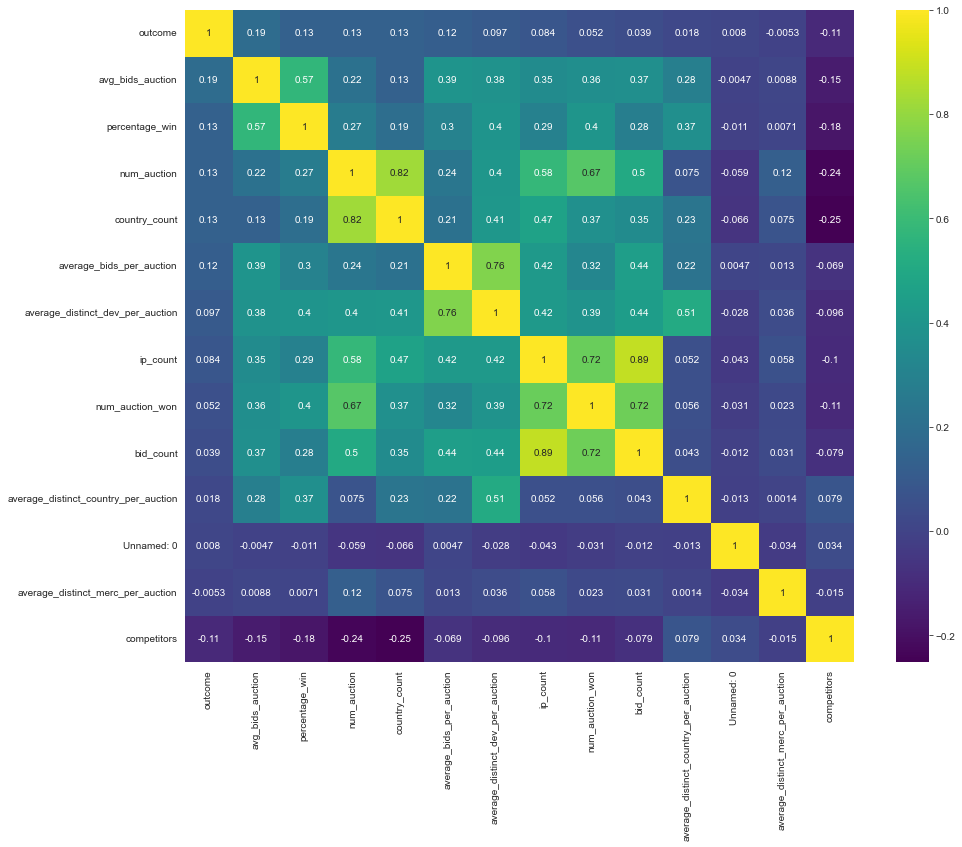

In [52]:
# Correlation matrix
corr_matrix = df_upsampled_unique.corr()
outcome_corr = corr_matrix['outcome'].sort_values(ascending=False)
plt.figure(figsize=(15, 12))
sns.heatmap(df[outcome_corr.index].corr(), annot=True, cmap='viridis')


# Suppression des Caractéristiques
En se basant sur le pairplot et la matrice de corrélation, nous avons pris la décision de supprimer certaines caractéristiques pour plusieurs raisons :

### Corrélation Faible avec la Variable Cible : 
Certaines caractéristiques peuvent avoir une corrélation faible avec la variable cible 'outcome', ce qui signifie qu'elles ne contribuent pas de manière significative à la prédiction du résultat de l'enchérisseur.

### Redondance des Caractéristiques : 
Certaines caractéristiques peuvent être fortement corrélées entre elles, ce qui signifie qu'elles fournissent des informations similaires. Dans ce cas, conserver toutes ces caractéristiques n'apporterait pas de bénéfice supplémentaire à notre modèle et pourrait introduire du bruit.

### Complexité Réduite du Modèle :
En supprimant les caractéristiques moins importantes, nous réduisons la complexité de notre modèle tout en préservant ses performances. Cela peut aider à améliorer l'interprétabilité du modèle et à réduire le risque de surajustement.


In [53]:
# List of features to drop
features_to_drop = ['bidder_id','num_auction_won', 'num_auction', 'bid_count', 'ip_count', 'country_count']

# Drop the features from the DataFrame
df_upsampled_unique.drop(features_to_drop, axis=1, inplace=True)

# Verify the DataFrame after dropping the features
df_upsampled_unique.head()


C:\Users\pc\AppData\Local\Temp\ipykernel_14088\3491675371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upsampled_unique.drop(features_to_drop, axis=1, inplace=True)


,Unnamed: 0,average_distinct_country_per_auction,average_distinct_dev_per_auction,average_distinct_merc_per_auction,average_bids_per_auction,percentage_win,avg_bids_auction,competitors,outcome
0,0,1.023,1.432,1.0,1.659,0.0,0.000208,205.159091,0.0
1,1,1.778,1.556,1.0,3.000,0.0,0.000039,463.666667,0.0
2,2,1.000,1.000,1.0,1.500,0.0,0.000077,380.000000,0.0
3,3,1.000,1.000,1.0,1.000,0.0,0.000101,92.000000,0.0
6,6,1.000,1.000,1.0,1.000,0.0,0.000113,203.000000,0.0


# Analyse des Performances des Modèles de Classification

Les performances de plusieurs modèles de classification ont été évaluées pour prédire le résultat de l'enchérisseur, qu'il soit un bot ou un humain. Les modèles évalués comprennent la Régression Logistique, les Forêts Aléatoires, le Boosting de Gradient et la Machine à Vecteurs de Support (SVM).


Ces résultats soulignent les performances différentes des modèles pour la détection de fraudes dans les enchères en ligne. Alors que les Forêts Aléatoires et le Boosting de Gradient ont des performances comparables avec des scores de précision et de rappel plus élevés pour la classe 'Bot', la Régression Logistique et la SVM montrent des difficultés à prédire la classe 'Bot' avec une précision ou un rappel significatif. Il est important de prendre en compte ces résultats lors du choix du modèle à déployer pour la détection de fraudes, en tenant compte des objectifs spécifiques de précision et de rappel pour la classe cible.

C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression Accuracy: 93.95%
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       373
         1.0       0.00      0.00      0.00        24

    accuracy                           0.94       397
   macro avg       0.47      0.50      0.48       397
weighted avg       0.88      0.94      0.91       397




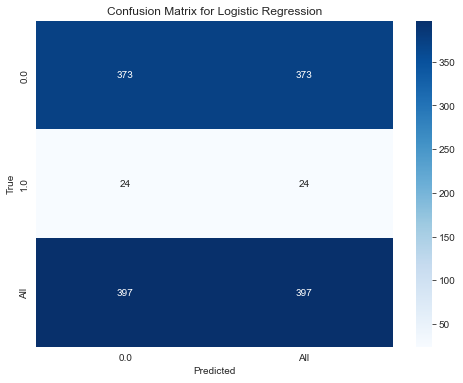

Random Forest Accuracy: 93.95%
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       373
         1.0       0.50      0.12      0.20        24

    accuracy                           0.94       397
   macro avg       0.72      0.56      0.58       397
weighted avg       0.92      0.94      0.92       397




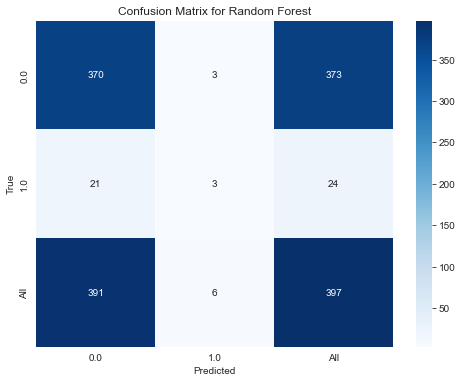

Gradient Boosting Accuracy: 94.46%
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       373
         1.0       0.60      0.25      0.35        24

    accuracy                           0.94       397
   macro avg       0.78      0.62      0.66       397
weighted avg       0.93      0.94      0.93       397




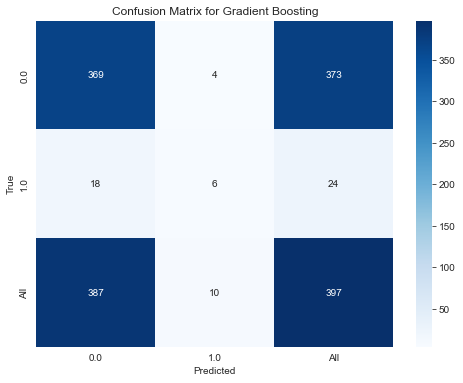

SVM Accuracy: 93.95%
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       373
         1.0       0.00      0.00      0.00        24

    accuracy                           0.94       397
   macro avg       0.47      0.50      0.48       397
weighted avg       0.88      0.94      0.91       397




C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


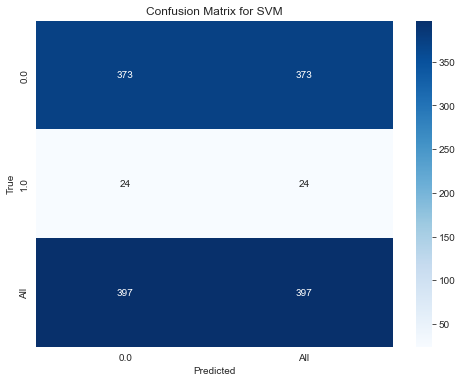

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_upsampled_unique.drop('outcome', axis=1), df_upsampled_unique['outcome'], test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# Fit models and make predictions
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# Evaluate models
for name, preds in predictions.items():
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    
    print(f"{name} Accuracy: {accuracy:.2%}\n{report}\n")
    
    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.crosstab(y_test, preds, rownames=['True'], colnames=['Predicted'], margins=True), annot=True, fmt='g', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


# Conclusion

Ce projet de détection de fraudes dans les enchères en ligne a abouti à la création et à l'évaluation de modèles de classification pour identifier les comportements suspects des enchérisseurs, en se concentrant sur la détection des bots. Après avoir extrait et traité les caractéristiques des enchérisseurs, nous avons utilisé des techniques de gestion des données déséquilibrées et évalué plusieurs modèles, dont les Forêts Aléatoires et le Boosting de Gradient. Les résultats montrent que ces modèles ont obtenu les meilleures performances pour détecter les bots, ce qui constitue une avancée significative dans la sécurisation des enchères en ligne contre la fraude.